**General**
For ease of use, we recommend downloading the original Real-ESRGAN reposetory (https://github.com/xinntao/Real-ESRGAN), and uploading the folder to a google colab.
In any case, in order to run this notebook it is required to put it int the Real-ESRGAN folder.

The notebook is comprosed of 2 sections, training and inference. If only one is required, skip the irrelevent part.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# !cp -r /content/drive/MyDrive/Real-ESRGAN-master/* .

In [ ]:
import os
# Install basicsr - https://github.com/xinntao/BasicSR
# We use BasicSR for both training and inference
!pip install basicsr
# facexlib and gfpgan are for face enhancement
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop
!pip install piqa

## Dataset Preparation

We have low quality (LQ) images at the input and high quality images (HQ) at the output. HQ images are used as ground-truth. 

The input images must have 256x16 and the output 1024x64.

For training, we used the sequence 00 from Semantic-Kitti dataset, with 9k images.

The scheme path to the directories are:

- datasets/
    - meta_info_pair.txt
    - input
        - splited_images
            - 00
            - test
    - output
        - original_images

The follow steps are in [github.com/xinntao/Real-ESRGAN/blob/master/docs/Training.md](https://github.com/xinntao/Real-ESRGAN/blob/master/docs/Training.md#computer-how-to-trainfinetune-real-esrgan)


In [36]:
dataset_path = "/mnt/d/Dev/Projects/Lume/super_resolution/datasets/"
input_path = os.path.join(f"{dataset_path}","input","splited_images") # LQ
output_path = os.path.join(f"{dataset_path}","output","original_imgs") # HQ

# Directories for train, test, and validation splits
train_dir = os.path.join(f"{dataset_path}", "train")
test_dir_hq = os.path.join(f"{dataset_path}","test" ,"hq")
test_dir_lq = os.path.join(f"{dataset_path}","test" ,"lq")
val_dir_hq = os.path.join(f"{dataset_path}", "validation", "hq")
val_dir_lq = os.path.join(f"{dataset_path}", "validation", "lq")

# Createthe directorys if they not exists
if not os.path.exists(train_dir):
    os.makedirs(train_dir, exist_ok=True)
if not os.path.exists(test_dir):
    os.makedirs(test_dir, exist_ok=True)
if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)

Rename the files in the output folder so that they have the same file name as the input folder

In [ ]:
import os

# rename validation files name
def rename_files(directory):
    # List all files in the specified directory
    files = os.listdir(directory)
    print(f"path {directory}")
    for file in files:
        # Check if the file name contains "_original"
        print(f"checking file: {file}")
        if '_original' in file:
            # Generate the new file name by removing "_original"
            new_name = file.replace('_original', '')

            # Rename the file
            os.rename(os.path.join(directory, file), os.path.join(directory, new_name))


# Rename the files
rename_files(val_dir_hq)
rename_files(val_dir_lq)

if you want to organize the dataset directories to the format: datasets > input > 00 > 00_image.png

In [ ]:
def organize_files(base_directory):
    # List all files in the base directory
    files = os.listdir(base_directory)
    print(f"Organizando {base_directory}...")

    for file in files:
        # Skip directories, we only want to move files
        if os.path.isfile(os.path.join(base_directory, file)):
            # Extract the prefix (first two characters) from the filename
            prefix = file[:2]
            print(f"Ordem {prefix}...")

            # Create a new directory with the prefix if it doesn't already exist
            new_directory = os.path.join(base_directory, prefix)
            if not os.path.exists(new_directory):
                os.makedirs(new_directory)

            # Move the file to the new directory
            shutil.move(os.path.join(base_directory, file), os.path.join(new_directory, file))

# Organize the files
organize_files(input_path)
organize_files(output_path)

If you wanna organize the directory with all the images on train, test and validation:

In [13]:
from sklearn.model_selection import train_test_split

file_list = os.listdir(input_path)

# Split the dataset into feature and target sets
train_files, test_files = train_test_split(file_list, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

**Validation**

To use the validation, we must create lower resultion versions of the same images.

Originally, for HQ images we had dimensions of 1024x64 and 1024x16 for LQ images. To use this model, we must have images with a dimension that is divisible by 4, and when upscaling the scale, corresponds to the dimension of the HQ image. To do this, we resize the LQ images by processing and dividing the image through columns of pixels,
using the file **split_images.py**.

## FINETUNE

As we already have both directorys (input LQ and output HQ), we'll finetuning the model with our own paired data. For this, we will use pair directories as input and output, and the config file meta_train_pair.txt.

The original Real-ESRGAN repo requires to create a meta info file for the train dataset. This cell will run a script to generate exactly that.

The following steps are originally from https://github.com/xinntao/Real-ESRGAN/blob/master/docs/Training.md#use-your-own-paired-data

In [ ]:
# Create meta info file for pair datasets
!python scripts/generate_meta_info_pairdata.py --input /datasets/output/original_imgs/00 /datasets/input/splited_images/00 --meta_info /datasets/meta_info_train.txt

Here we shall download the original Real-ESRGAN weights. If you are going to work on different weights, you can skip this part.

In [ ]:
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.2.3/RealESRGAN_x4plus_netD.pth -P experiments/pretrained_models

And finally, run this cell in order to strat the training process.

In [ ]:
!python realesrgan/train_finetune_architecture.py -opt options/finetune_realesrgan_x4plus_pairdata.yml --auto_resume

We will also need to copy the new weights to the wegihts folder from the experiment folder

In [ ]:
# !cp experiments/finetune_RealESRGANx4plus_400k/models/net_g_latest.pth weights/net_g_latest.pth
!cp /experiments/finetune_RealESRGANx4plus_400k_pairdata/models/net_g_latest.pth weights/net_g_latest.pth

Now we shall test the trained model. Similiar to the validation set, we first must create the lower resoultion versions of the test set.

**Inference and Test**

In [ ]:
# test
!cp -v /mnt/d/Dev/Projects/Lume/super_resolution/datasets/output/original_imgs/01/*.png /mnt/d/Dev/Projects/Lume/super_resolution/datasets/test/hq/ # 11k

Finally, we can run the inference script in order ro get the test results

In [ ]:
# !python inference_realesrgan_architecture.py -n net_g_latest.pth -i inputs_test --outscale 2 --output new_model_results
!python inference_realesrgan.py -n net_g_latest.pth -i /datasets/input/splited_images/01/test --outscale 4 --output new_model_results

Or we can infer with previosly fine tuned model

In [16]:
# !python inference_realesrgan.py -n net_g_architecture.pth -i /mnt/d/Dev/Projects/Lume/super_resolution/datasets/input/splited_images/01/test --outscale 4 --output /mnt/d/Dev/Projects/Lume/super_resolution/datasets/input/splited_images/01/results
!python inference_realesrgan.py -n net_g_architecture.pth -i /datasets/input/splited_images/01/LR_results

net_g_architecture
weights/net_g_architecture.pth
4
Testing 0 1_000097
Testing 1 1_000119
Testing 2 2_000097
Testing 3 2_000119
Testing 4 3_000097
Testing 5 3_000119
Testing 6 4_000097
Testing 7 4_000119


If there is a need, you could run the cell below in order to use the original Real-ESRGAN weights, and to test them

In [ ]:
!python inference_realesrgan_architecture.py -n RealESRGAN_x4plus -i inputs_test --outscale 2 --output golden_results

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
Testing 0 downscale_F176_VOX_arquitectura_Beam_
Testing 1 downscale_F176_VOX_arquitectura_Door_Beam_Handrail_
Testing 2 downscale_F176_VOX_arquitectura_Drawings_
Testing 3 downscale_F176_VOX_arquitectura_Facade_Handrail_
Testing 4 downscale_F176_VOX_arquitectura_Facade_Windows_
Testing 5 downscale_F176_VOX_arquitectura_Fence_Facade_Handrail_
Testing 6 downscale_F176_VOX_arquitectura_Stairs_Handrail_Steel_
Testing 7 downscale_F176_VOX_arquitectura_Windows_
Testing 8 downscale_F176_VOX_arquitectura_Windows_Brick_Facade_
Testing 9 downscale_F176_VOX_arquitectura_Windows_Facade_
Testing 10 downscale_F176_VOX_arquitectura_Windows_Fa

If there is a need to comapre metric results, modify this code to your needs.

In [ ]:
import torchvision.transforms as transforms
from basicsr.metrics import calculate_ssim, calculate_psnr, calculate_niqe
import torch
import piqa
from os.path import exists
psnr = piqa.PSNR()
ssim = piqa.ssim.SSIM()
avg_our_niqe = 0.0
avg_orig_niqe = 0.0
avg_gold_niqe = 0.0
avg_our_psnr = 0.0
avg_gold_psnr = 0.0
avg_gt_psnr = 0.0
total_files = 0
for filename in glob.glob('datasets/modernarchitecture/test/hq/*.jpg'):
    head, tail = os.path.split(filename)
    golden_result = Image.open('golden_results/downscale_'+tail[:-4]+'_out.jpg')
    our_result = Image.open('our_results/downscale_'+tail[:-4]+'_out.jpg')
    gt = Image.open(filename)
    our_result = our_result.resize((gt.size[0], gt.size[1]))
    golden_result = golden_result.resize((gt.size[0], gt.size[1]))
    transform = transforms.PILToTensor()
    golden_result = transform(golden_result)
    our_result = transform(our_result)
    gt = transform(gt)
    if(our_result.numpy().shape[0] == 3 and gt.numpy().shape == our_result.numpy().shape and gt.numpy().shape == golden_result.numpy().shape):
      avg_our_niqe += calculate_niqe(img = our_result.numpy(), crop_border=4, test_y_channel=False, input_order='CHW' ,convert_to='gray')
      avg_orig_niqe += calculate_niqe(img = gt.numpy(), crop_border=4, test_y_channel=False, input_order='CHW' ,convert_to='gray')
      avg_gold_niqe += calculate_niqe(img = golden_result.numpy(), crop_border=4, test_y_channel=False, input_order='CHW' ,convert_to='gray')
      avg_our_psnr += psnr(our_result.type(torch.float)/255, gt.type(torch.float)/255)
      avg_gold_psnr += psnr(golden_result.type(torch.float)/255, gt.type(torch.float)/255)
      avg_gt_psnr += psnr(gt.type(torch.float)/255, gt.type(torch.float)/255)
    total_files += 1
avg_our_niqe /= total_files
avg_orig_niqe /= total_files
avg_gold_niqe /= total_files
avg_our_psnr /= total_files
avg_gold_psnr /= total_files
avg_gt_psnr /= total_files
print("avg_our_niqe", avg_our_niqe, "avg_orig_niqe ", avg_orig_niqe, "avg_gold_niqe", avg_gold_niqe)
print("avg_our_psnr", avg_our_psnr, "avg_gold_psnr ", avg_gold_psnr, "avg_gt_psnr", avg_gt_psnr)


avg_our_niqe 4.36796694945366 avg_orig_niqe  3.40678806614249 avg_gold_niqe 4.437186537028811
avg_our_psnr tensor(21.8031) avg_gold_psnr  tensor(22.2831) avg_gt_psnr tensor(70.)


Here is an example of how to cut a snippet of the images to focus on specific parts of an image

In [ ]:
!mkdir patches/
from PIL import Image
import glob
ext = ".jpg"
og_filename = "F176_VOX_arquitectura_Beam_"
changed_filename = "downscale_" + og_filename + "_out"
images = []
catgories = ["our", "golden", "og"]
for category in catgories:
  if category == "og":
    image = Image.open("datasets/modernarchitecture/test/hq/" + og_filename + ".jpg")
  else:
    image = Image.open(category + "_results/" + changed_filename + ".jpg")

  width, height = image.size
  left = 0
  top = 0
  right = width / 3
  bottom = height / 6

  image = image.crop((left, top, right, bottom))
  images.append(image)

  image.save("patches/patch_" + category + "_" + og_filename + ext)

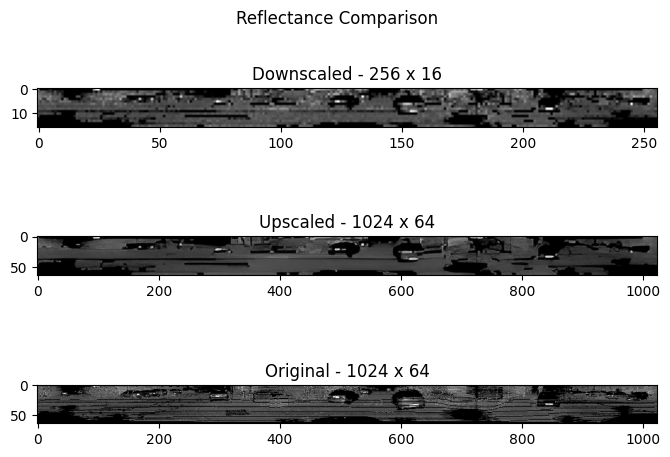

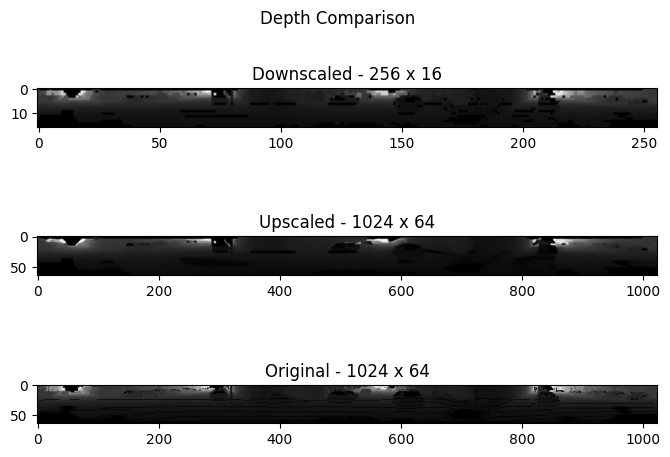

TypeError: Image data of dtype object cannot be converted to float

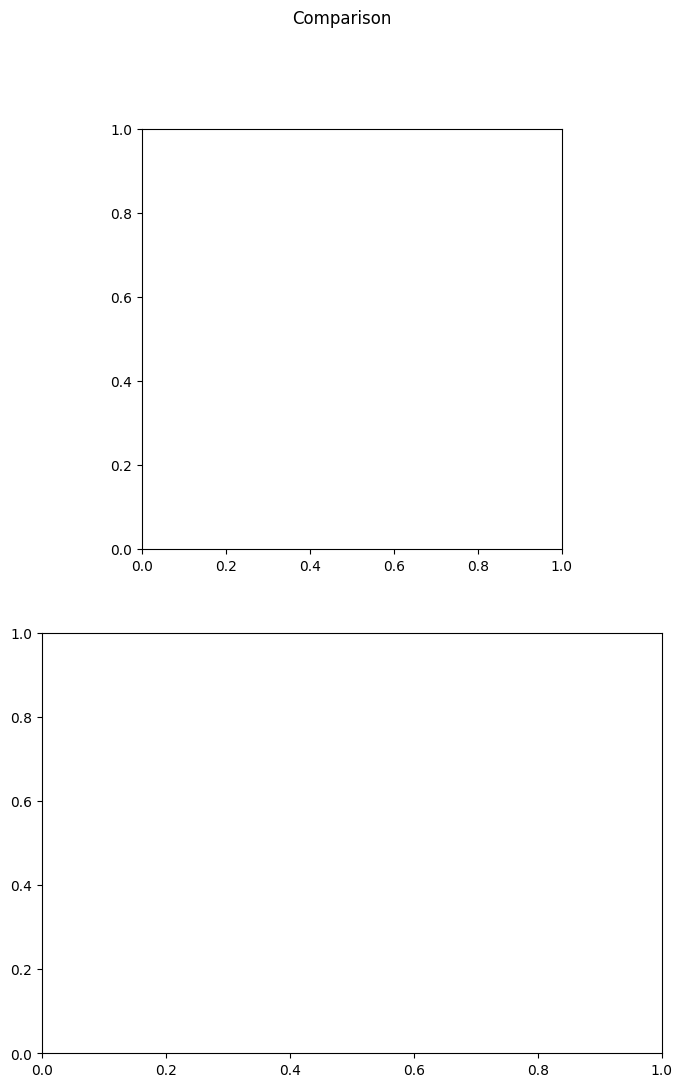

In [72]:
from PIL import Image # pip install pillow

import matplotlib.pyplot as plt # pip install matplotlib

# Load the images
orig1 = Image.open("images/hq/original/01_frame_000124_depth_original.png")
orig2 = Image.open("images/hq/original/01_frame_000124_reflectance_original.png")
orig3 = Image.open("images/hq/original/01_frame_000054_depth_original.png")
orig4 = Image.open("images/hq/original/01_frame_000054_reflectance_original.png")

downscale1 = Image.open("images/lq/01_frame_000124_depth.png")
downscale2 = Image.open("images/lq/01_frame_000124_reflectance.png")
downscale3 = Image.open("images/lq/01_frame_000054_depth.png")
downscale4 = Image.open("images/lq/01_frame_000054_reflectance.png")

upscale1 = Image.open("images/hq/upscaled/01_frame_000124_depth_out.png")
upscale2 = Image.open("images/hq/upscaled/01_frame_000124_reflectance_out.png")
upscale3 = Image.open("images/hq/upscaled/01_frame_000054_depth_out.png")
upscale4 = Image.open("images/hq/upscaled/01_frame_000054_reflectance_out.png")

# reflectance images

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))
fig.suptitle('Reflectance Comparison')

axs[0].imshow(downscale4, cmap='gray')
axs[0].set_title('Downscaled - 256 x 16')
axs[1].imshow(upscale4, cmap='gray')
axs[1].set_title('Upscaled - 1024 x 64')
axs[2].imshow(orig4, cmap='gray')
axs[2].set_title('Original - 1024 x 64')

fig.subplots_adjust(top=0.95, bottom=0.6)
plt.show()

# depth images

fig2, axs2 = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))
fig2.suptitle('Depth Comparison')

axs2[0].imshow(downscale3, cmap='gray')
axs2[0].set_title('Downscaled - 256 x 16')
axs2[1].imshow(upscale3, cmap='gray')
axs2[1].set_title('Upscaled - 1024 x 64')
axs2[2].imshow(orig3, cmap='gray')
axs2[2].set_title('Original - 1024 x 64')

fig2.subplots_adjust(top=0.95, bottom=0.6)
plt.show()